**IMPORT LIBRARIES**

In [66]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

**LOADING DATA**

In [67]:
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

In [68]:
def get_data(data_dir) :
    images = []
    labels = []
    
    dir_list = os.listdir(data_dir)
    for i in range(len(dir_list)):
        print("Loading Folder ",i)
        for image in os.listdir(data_dir + "/" + dir_list[i]):
            img = cv2.imread(data_dir + '/' + dir_list[i] + '/' + image)
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(i)
    
    return images, labels
        
X, y = get_data(train_dir)

Loading Folder  0
Loading Folder  1
Loading Folder  2
Loading Folder  3
Loading Folder  4
Loading Folder  5
Loading Folder  6
Loading Folder  7
Loading Folder  8
Loading Folder  9
Loading Folder  10
Loading Folder  11
Loading Folder  12
Loading Folder  13
Loading Folder  14
Loading Folder  15
Loading Folder  16
Loading Folder  17
Loading Folder  18
Loading Folder  19
Loading Folder  20
Loading Folder  21
Loading Folder  22
Loading Folder  23
Loading Folder  24
Loading Folder  25
Loading Folder  26
Loading Folder  27
Loading Folder  28


**NORMALIZATION AND ONE HOT ENCODING**

In [69]:
def preprocess_data(X, y):
    np_X = np.array(X)
    normalised_X = np_X.astype('float32') / 255.0

    label_encoded_y = utils.to_categorical(y)

    x_train, x_test, y_train, y_test = train_test_split(normalised_X, label_encoded_y, test_size=0.1)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocess_data(X, y)

print("Training data:", x_train.shape)
print("Test data:", x_test.shape)


Training data: (78300, 32, 32, 3)
Test data: (8700, 32, 32, 3)


**DATA AUGUMENTATION**

In [70]:

datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformations
    zoom_range=0.2,         # Apply random zoom between 80% and 120%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in newly created pixels (e.g., after rotation) with the nearest available pixel value
)


datagen.fit(X)

**DEFINING THE CLASSES**

In [71]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

**DEFINING THE MODEL**

In [72]:
classes = len(classes)
batch = 32
epochs = 20
learning_rate = 0.001


For our model, let us initialize a Keras Sequential model. This model architecture comprises four layers, forming a deep Convolutional Neural Network (CNN). To enhance the model's performance and prevent overfitting on the training data, we've incorporated batch normalization and dropout layers. Additionally, max-pooling operations are employed for down-sampling.

Adam is used as the optimizer here, with a learning rate of 0.001. This optimizer helps efficiently update the model's weights during training.

Since this is a multiclass classification task, categorical crossentropy is chosen as the loss function. It is well-suited for scenarios where data is categorized into multiple classes.

The model is trained with the objective of maximizing accuracy, which is a key metric for assessing its performance. Through a series of experiments with different layer configurations, we aim to achieve the highest possible validation accuracy.

In [73]:

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation="softmax"))

# Compile the model
adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                      

**TRAIN MODEL**

In [74]:

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/20
2447/2447 [==============================] - 232s 93ms/step - loss: 2.0197 - accuracy: 0.4054 - val_loss: 0.6260 - val_accuracy: 0.7746
Epoch 2/20
2447/2447 [==============================] - 226s 92ms/step - loss: 0.9112 - accuracy: 0.6925 - val_loss: 1.1805 - val_accuracy: 0.6264
Epoch 3/20
2447/2447 [==============================] - 224s 92ms/step - loss: 0.6432 - accuracy: 0.7822 - val_loss: 0.1616 - val_accuracy: 0.9468
Epoch 4/20
2447/2447 [==============================] - 225s 92ms/step - loss: 0.5254 - accuracy: 0.8225 - val_loss: 0.4070 - val_accuracy: 0.8691
Epoch 5/20
2447/2447 [==============================] - 225s 92ms/step - loss: 0.4553 - accuracy: 0.8471 - val_loss: 0.5479 - val_accuracy: 0.8468
Epoch 6/20
2447/2447 [==============================] - 224s 92ms/step - loss: 0.4150 - accuracy: 0.8606 - val_loss: 0.1062 - val_accuracy: 0.9645
Epoch 7/20
2447/2447 [==============================] - 225s 92ms/step - loss: 0.3676 - accuracy: 0.8770 - val_loss: 0

**MODEL EVALUATION**

In [75]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


272/272 [==============================] - 6s 21ms/step - loss: 0.0204 - accuracy: 0.9938
Test accuracy: 0.9937931299209595
Test loss: 0.020440727472305298


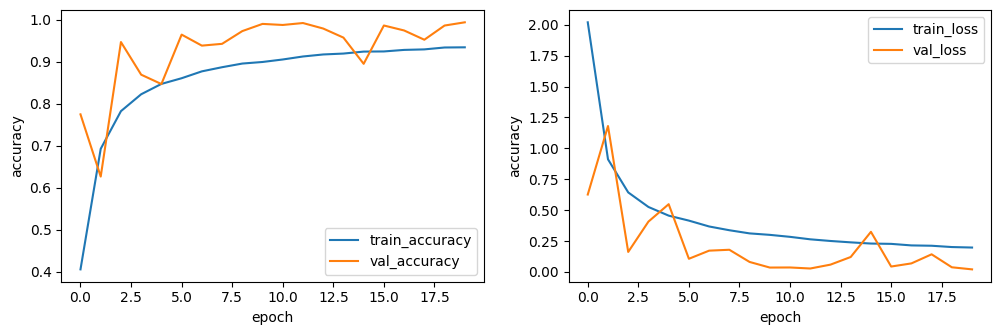

In [76]:
def plot_results(model):

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()


    
plot_results(model)